In [1]:
%matplotlib inline

# Isochrone fitting using gaia-isochrones

In this demo, we'll fit the Gaia data for a TESS target.
The stack is:

* [MIST](http://waps.cfa.harvard.edu/MIST/) stellar evolution and atmospheric grids,
* [isochrones.py](https://github.com/timothydmorton/isochrones) to compute the model, and
* [dynesty](https://dynesty.readthedocs.io) to do the parameter estimation.

But first, let's set up the plotting to look a little nicer:

In [2]:
import matplotlib.pyplot as plt
plt.style.use("default")
plt.rcParams["savefig.dpi"] = 100
plt.rcParams["figure.dpi"] = 100
plt.rcParams["font.size"] = 16
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = ["Liberation Sans"]
plt.rcParams["mathtext.fontset"] = "custom"

Then, all of our imports:

In [3]:
import gaia_isochrones

import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord

Created TAP+ (v1.0.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: False
	Port: 80
	SSL Port: 443


In this demo, we'll fit the stellar properties for HD 21749, one of the TESS targets that [was found to host a system of transiting planets](https://ui.adsabs.harvard.edu/abs/2019ApJ...875L...7D/abstract).
In practice, it would be easier to use the shortcuts in `gaia_isochrones.tess` to do this fit, but for completeness, we'll start from scratch here.

We extract the coordinates and TESS magnitude of the target from the paper and then query the Gaia catalog at those coordinates:

In [4]:
ra = "03:27:00.045"
dec = "-63:30:00.60"
coord = SkyCoord(ra, dec, unit=(u.hourangle, u.deg), obstime="J2015.5")
tess_mag = 6.95

gaia_data = gaia_isochrones.get_gaia_data(coord, approx_mag=tess_mag)
print(gaia_data)

Query finished.
{'G': array([7.67905712e+00, 2.60185873e-04]), 'BP': array([8.32860279e+00, 1.07686068e-03]), 'RP': array([6.95018673e+00, 1.37995569e-03]), 'parallax': array([6.13275193e+01, 4.22336409e-02]), 'max_distance': 100.0}


Then, we fit these data using dynesty to sample.
If we provide an `output_dir` argument then the results are saved to disk.

In [5]:
model, sampler = gaia_isochrones.fit_gaia_data("hd21749", gaia_data, output_dir="demo", clobber=True)

13358it [01:53, 66.01it/s, +133 | bound: 147 | nc: 1 | ncall: 133422 | eff(%): 10.112 | loglstar:   -inf < -7.403 <    inf | logz: -31.855 +/-  0.292 | dlogz:  0.388 >  0.509]


This function returns both the isochrones model and the dynesty `NestedSampler` object so we can do everything that we might want to do with those.

For example, we can make the corner plots that isochrones knows how to make:

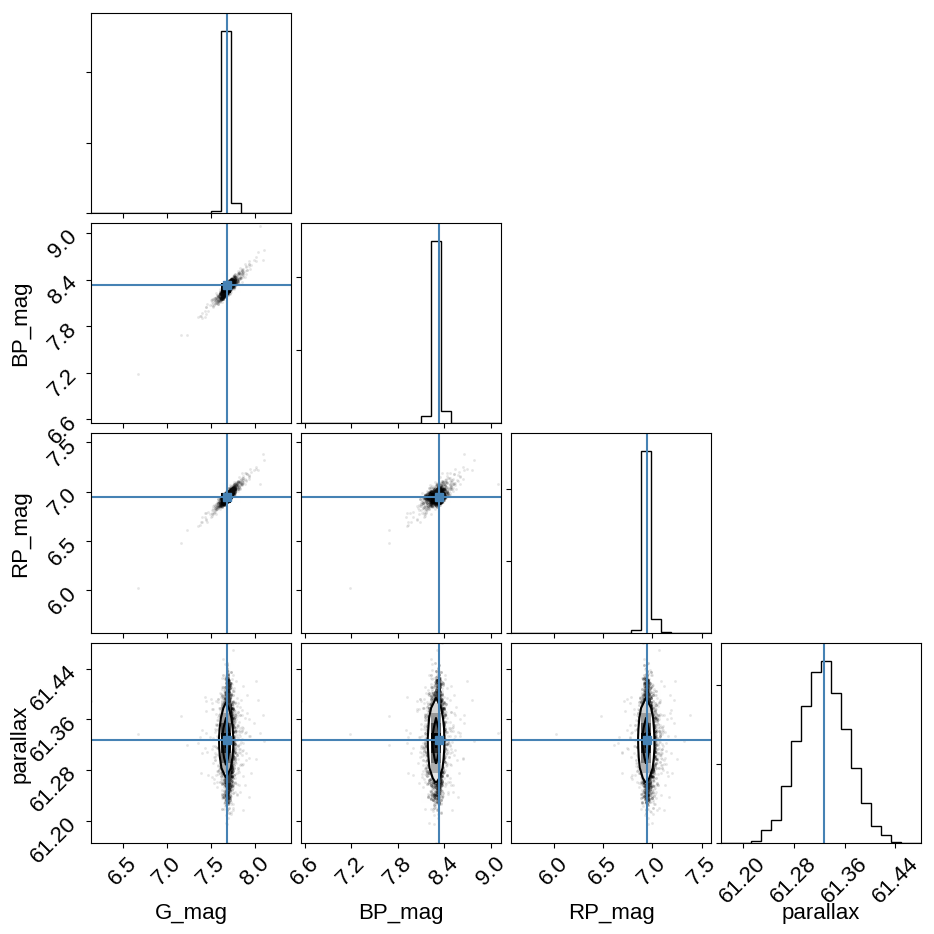

In [6]:
model.corner_observed();

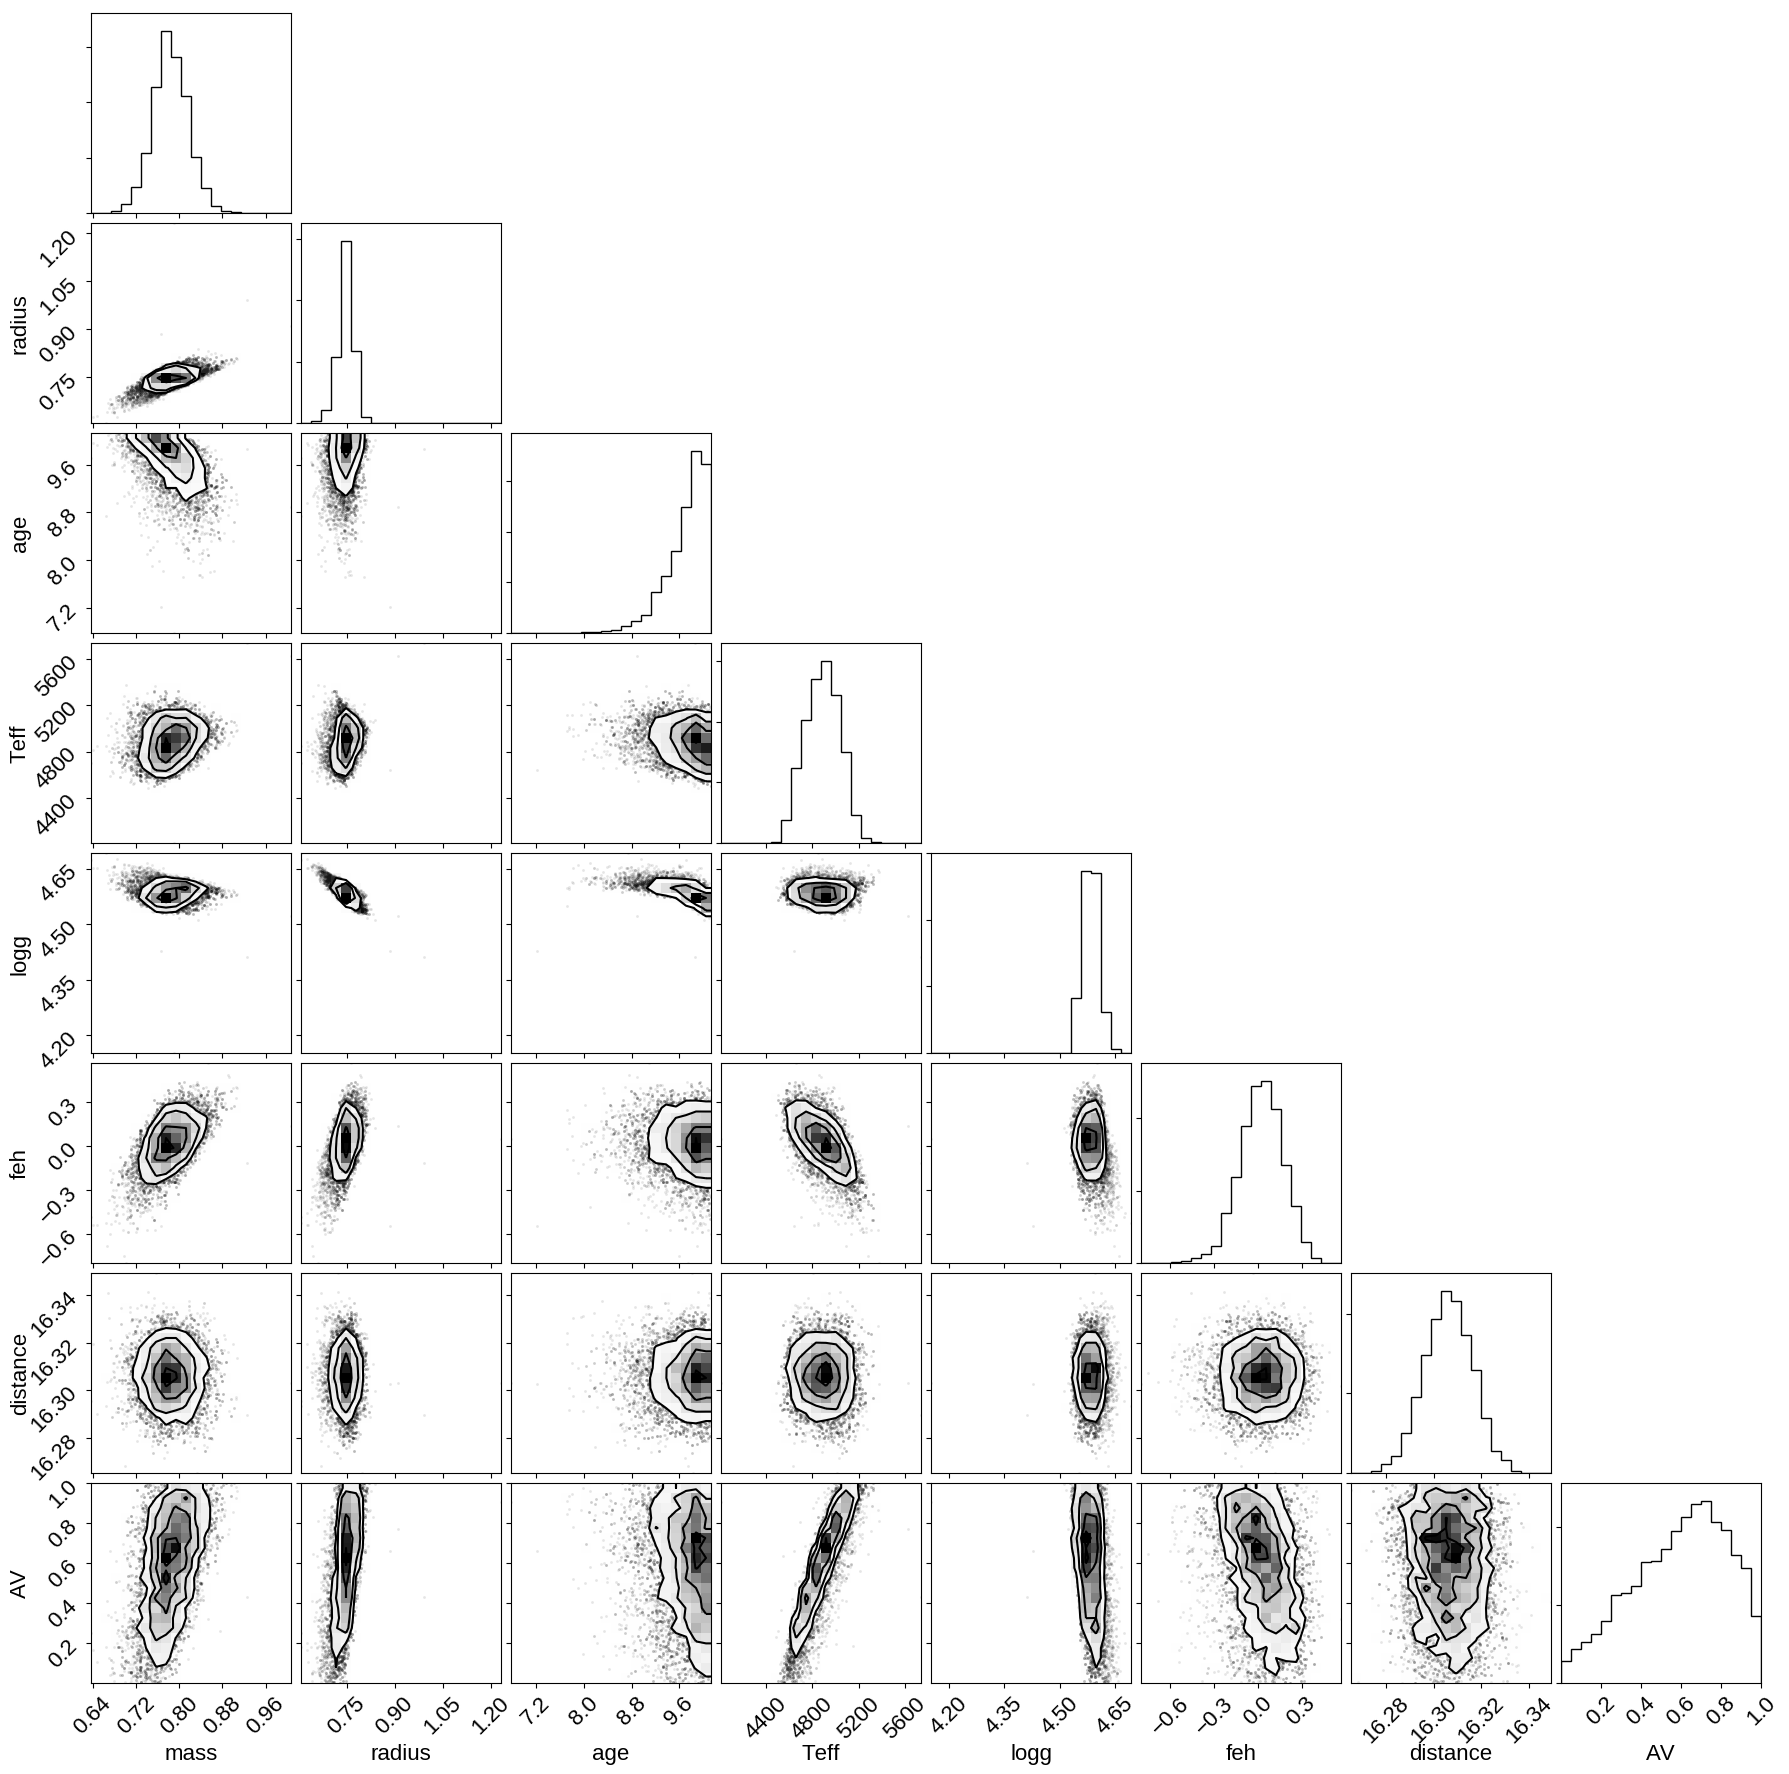

In [7]:
model.corner_physical();

Finally, let's summarize these results.
The raw samples are saved in the isochrones model as a pandas `DataFrame` called `_derived_samples`:

In [8]:
samples = model._derived_samples

for k in ["mass", "radius", "age", "Teff", "logg", "feh", "distance", "AV"]:
    x = samples[k]
    if k == "age":
        # "age" is actually "log10(age)"
        x = 10 ** (x - 9)
        k = "age [Gyr]"
    print("{0} = {1:.3f} ± {2:.3f}".format(k, np.mean(x), np.std(x)))

mass = 0.784 ± 0.033
radius = 0.747 ± 0.025
age [Gyr] = 6.322 ± 3.424
Teff = 4887.926 ± 146.152
logg = 4.584 ± 0.022
feh = 0.023 ± 0.150
distance = 16.306 ± 0.010
AV = 0.591 ± 0.234
